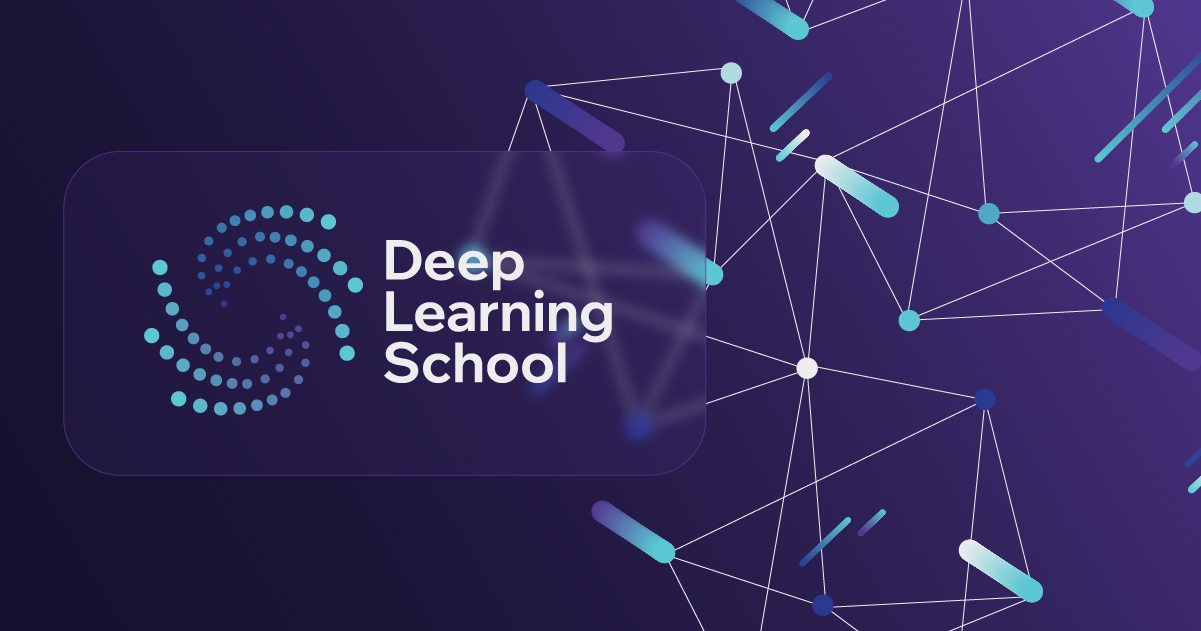


# Домашнее задание "Варианционные автоэнкодеры"

В этом домашнем задании вам предстоит реализовать несколько версий автоэнкодера для работы с изображениями.

Вы научитесь добавлять улыбку на фотографии людей, изменяя их исходное выражение лица с помощью обученной модели. А также, обучите ваш автоэнкодер генерировать изображения рукописных цифр.

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


Перед тем, как начинать работу с моделями нужно подготовить данные.

In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import imageio
from PIL import Image
import kagglehub

%matplotlib inline

В этом задании вам предстоить работать с датасетом [LFW (Labeled Faces in the Wild)](https://datasets.activeloop.ai/docs/ml/datasets/lfw-dataset/#:~:text=What%20is%20LFW%20Dataset%3F,commercial%20algorithms%20prior%20to%20release).

In [2]:
# Скачиваем картинки
images_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", images_path)

Path to dataset files: /kaggle/input/lfw-dataset


In [3]:
# Скачиваем атрибуты
attrs_path = kagglehub.dataset_download("averkij/lfw-attributes")
print("Path to dataset files:", attrs_path)

Path to dataset files: /kaggle/input/lfw-attributes


In [4]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

In [5]:
def fetch_dataset(dx=80, dy=80, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id,'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "Потеряны данные при объединении датафреймов!"

    images = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy, dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx, dimy])) )

    images = np.stack(images.values).astype('uint8')
    attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return images, attrs

In [6]:
# Обратите внимание, что датасет представляет собой не только картинки, но и атрибуты
# Атрибуты понадобятся в конце этого задания

images, attrs = fetch_dataset()
attrs = attrs.astype(np.float32)


Разбейте датасет изображений и атрибутов на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [7]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

img_train, img_val, attr_train, attr_val = train_test_split(
    images, attrs.values, test_size=0.2, random_state=52, shuffle=True
)



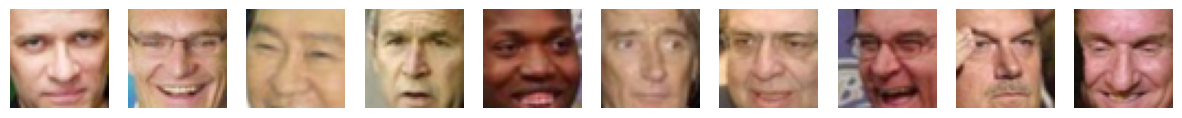

In [8]:
def show_images(images, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

show_images(img_train, n=10)

In [9]:
from torchvision import transforms
to_tensor = transforms.Compose([
    transforms.ToTensor(),
])

img_train_tensor = torch.stack([to_tensor(img) for img in img_train])
img_val_tensor = torch.stack([to_tensor(img) for img in img_val])
atr_train_tensor = torch.tensor(attr_train, dtype=torch.float32)
atr_val_tensor = torch.tensor(attr_val, dtype=torch.float32)

# Проверим размеры:
print("Train images:", img_train_tensor.shape)
print("Train labels:", atr_train_tensor.shape)
print("Val images:", img_val_tensor.shape)
print("Val labels:", atr_val_tensor.shape)

Train images: torch.Size([10514, 3, 45, 45])
Train labels: torch.Size([10514, 73])
Val images: torch.Size([2629, 3, 45, 45])
Val labels: torch.Size([2629, 73])


## 1.2. Архитектура модели (2 балла)
В этом разделе вы напишите и обучите обычный автоэнкодер.



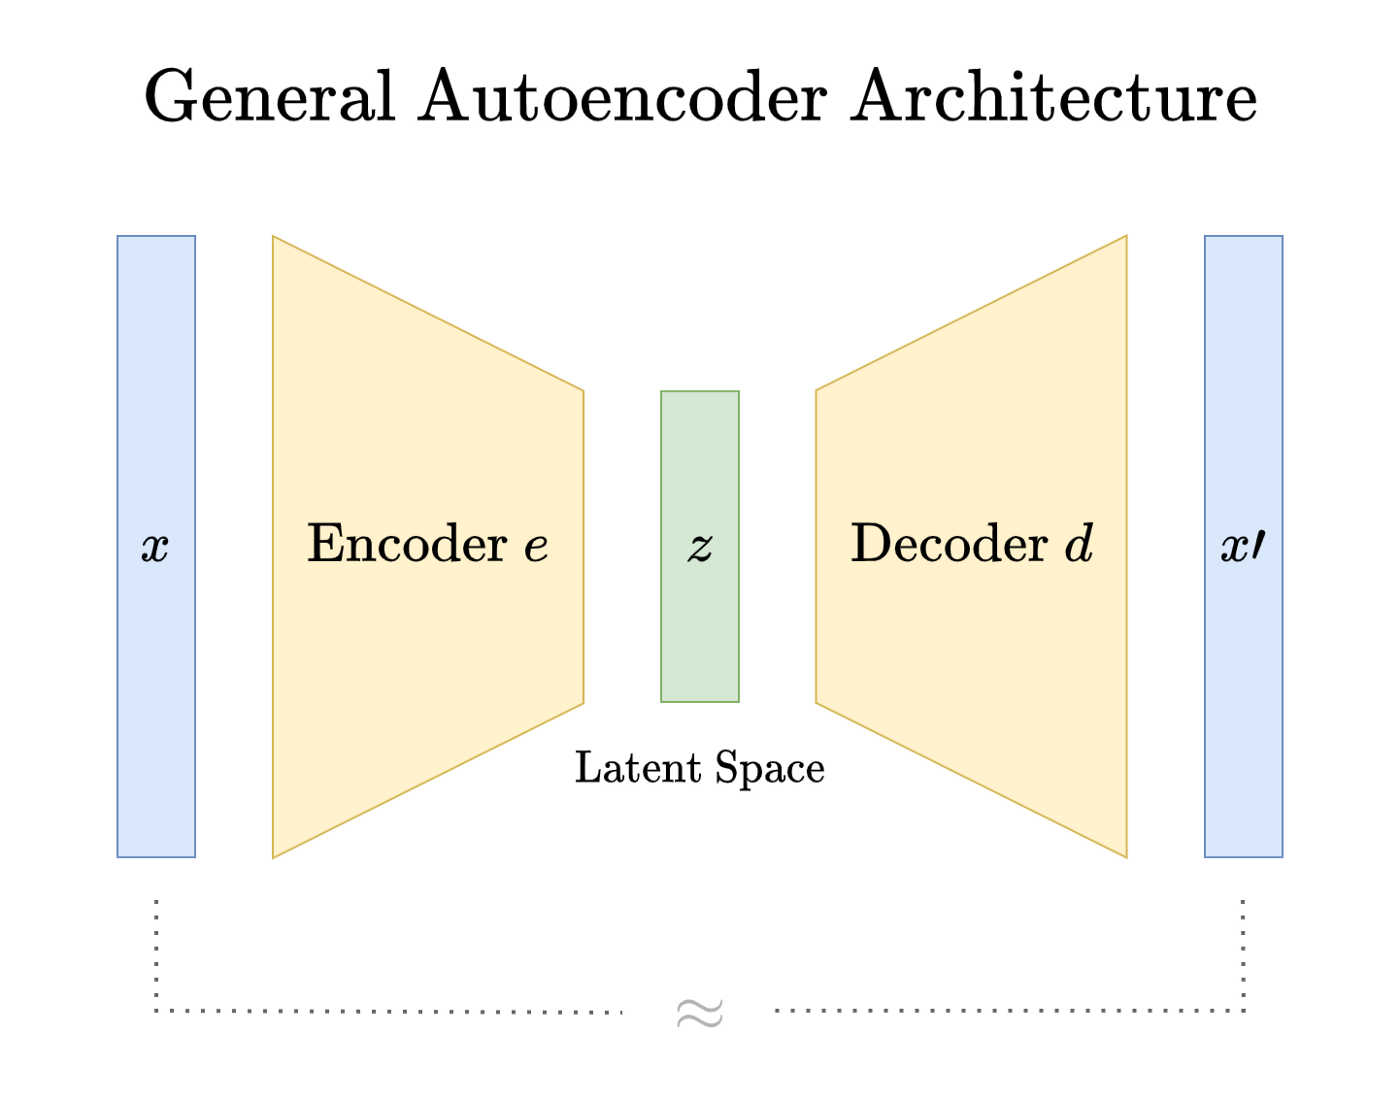

In [10]:
dim_code = 128 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Autoencoder, self).__init__()

        # Encoder: 3x45x45 -> latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # -> 32 x 23 x 23
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> 64 x 12 x 12
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# -> 128 x 6 x 6
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(128 * 6 * 6, latent_dim)

        # Decoder: latent_dim -> 3x45x45
        self.fc_dec = nn.Linear(latent_dim, 128 * 6 * 6)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 6, 6)),  # (B, 128, 6, 6)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (64, 12, 12)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> (32, 24, 24)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> (16, 48, 48)
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=4, stride=1),                                           # -> (3, 45, 45)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        latent_code = self.fc_enc(x)

        x = self.fc_dec(latent_code)
        reconstruction = self.decoder(x)

        return reconstruction, latent_code


In [12]:
criterion = nn.MSELoss()

autoencoder = Autoencoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [13]:
num_epochs = 20
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = TensorDataset(img_train_tensor, atr_train_tensor)
val_dataset = TensorDataset(img_val_tensor, atr_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
train_losses = []
val_losses = []
def show_reconstructions(model, dataloader, n=6):
    model.eval()
    with torch.no_grad():
        imgs, _ = next(iter(dataloader))
        imgs = imgs[:n].to(device)
        recons, _ = model(imgs)

        imgs = imgs.cpu().numpy()
        recons = recons.cpu().numpy()

        plt.figure(figsize=(12, 4))
        for i in range(n):
            # Оригинал
            plt.subplot(2, n, i+1)
            plt.imshow(np.transpose(imgs[i], (1, 2, 0)))
            plt.axis("off")
            # Реконструкция
            plt.subplot(2, n, i+n+1)
            plt.imshow(np.transpose(recons[i], (1, 2, 0)))
            plt.axis("off")
        plt.suptitle("Top: Original, Bottom: Reconstructed", fontsize=12)
        plt.show()

Epoch  1 | Train Loss: 0.0216 | Val Loss: 0.0102


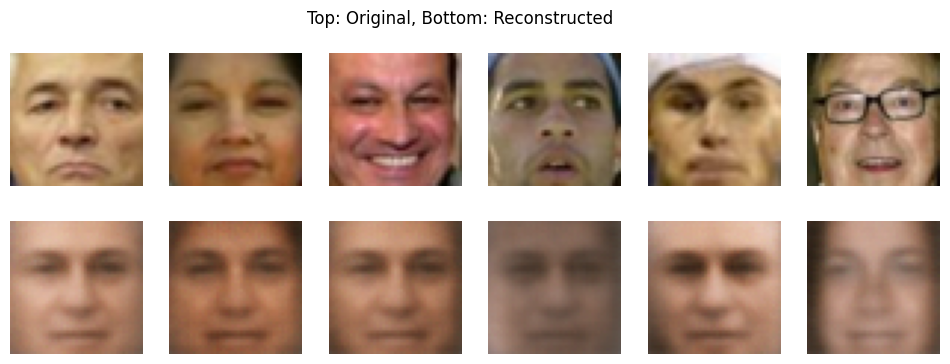

Epoch  2 | Train Loss: 0.0079 | Val Loss: 0.0065


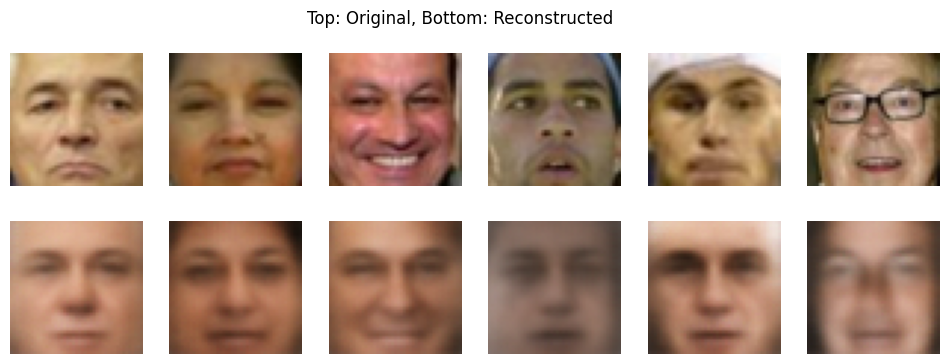

Epoch  3 | Train Loss: 0.0057 | Val Loss: 0.0051


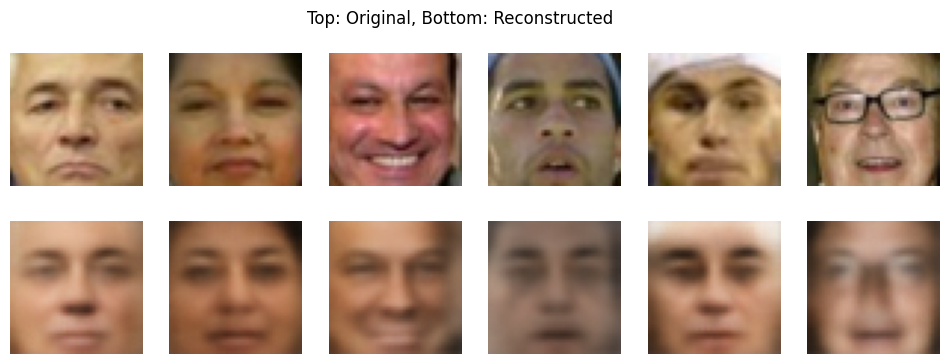

Epoch  4 | Train Loss: 0.0047 | Val Loss: 0.0044


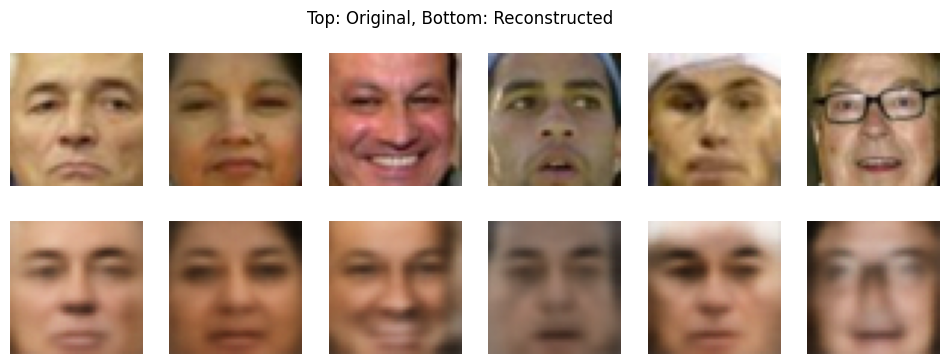

Epoch  5 | Train Loss: 0.0041 | Val Loss: 0.0040


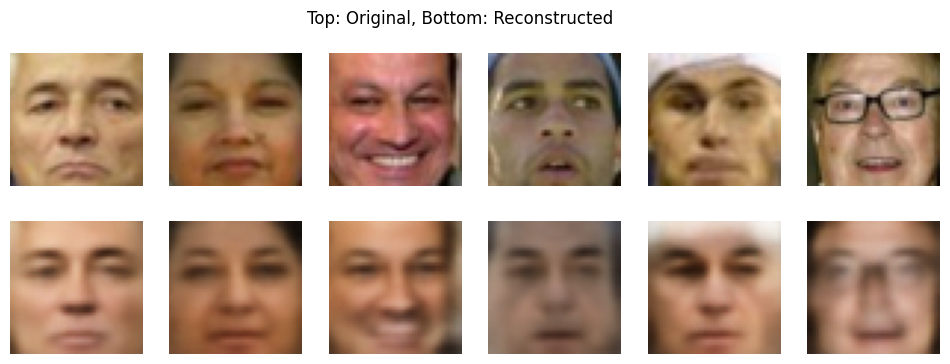

Epoch  6 | Train Loss: 0.0037 | Val Loss: 0.0035


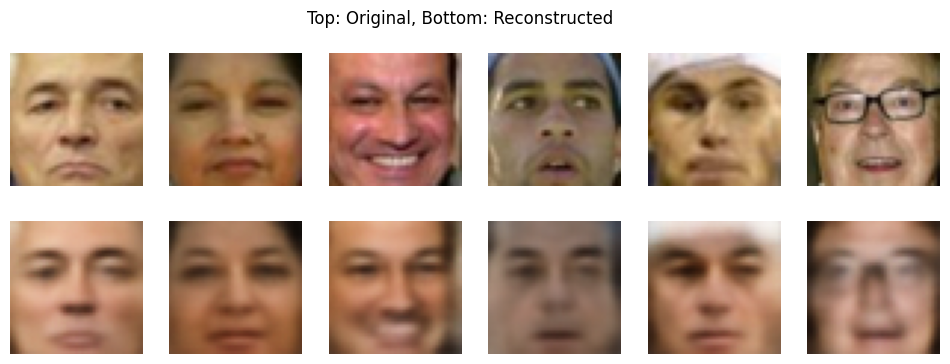

Epoch  7 | Train Loss: 0.0034 | Val Loss: 0.0033


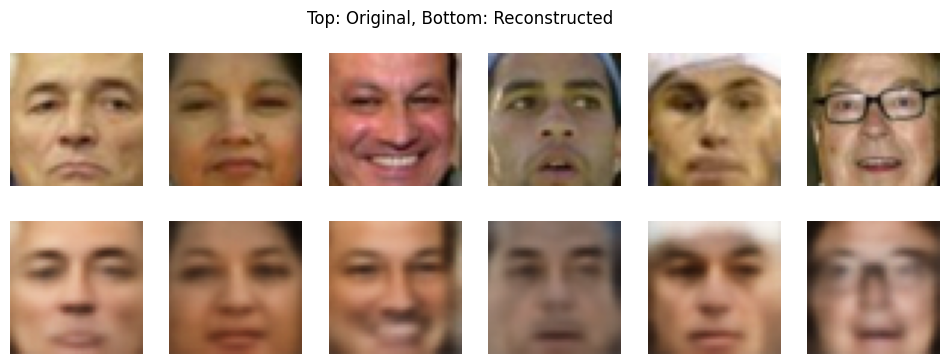

Epoch  8 | Train Loss: 0.0031 | Val Loss: 0.0031


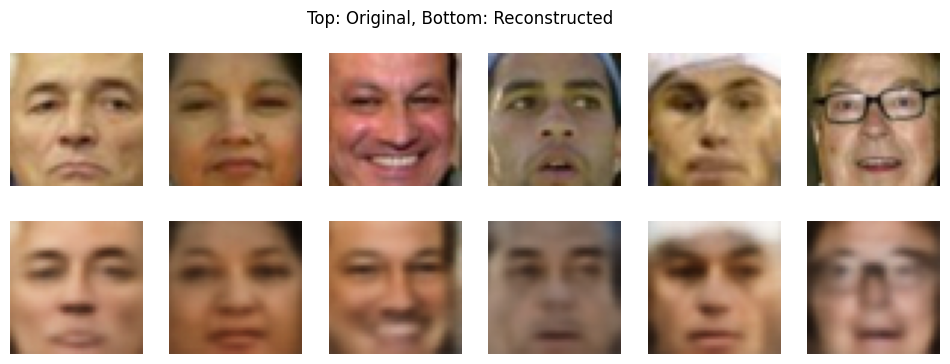

Epoch  9 | Train Loss: 0.0029 | Val Loss: 0.0029


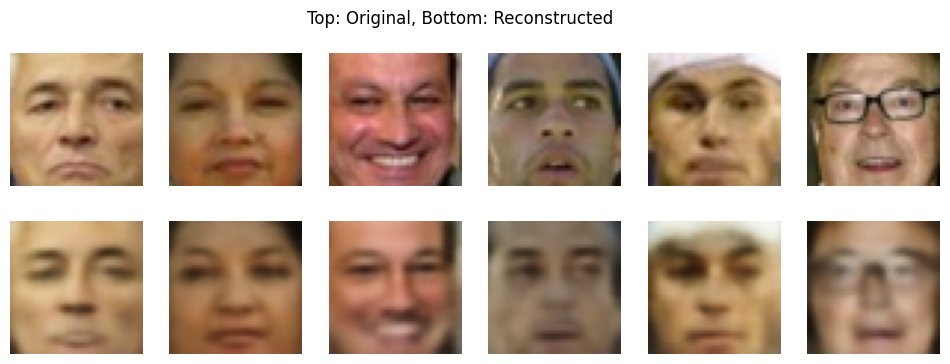

Epoch 10 | Train Loss: 0.0027 | Val Loss: 0.0027


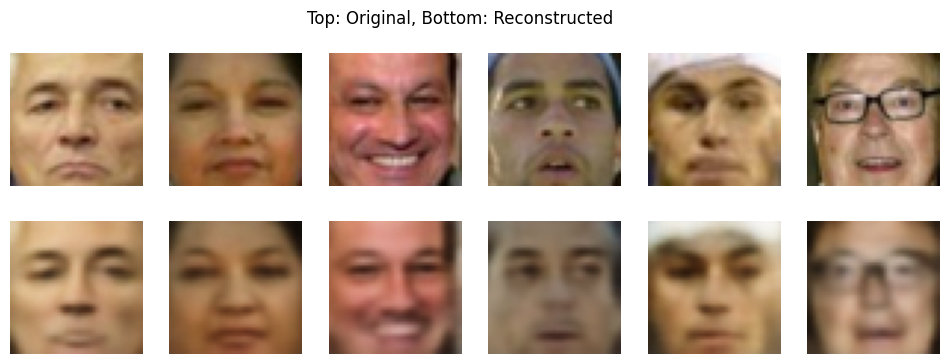

Epoch 11 | Train Loss: 0.0026 | Val Loss: 0.0026


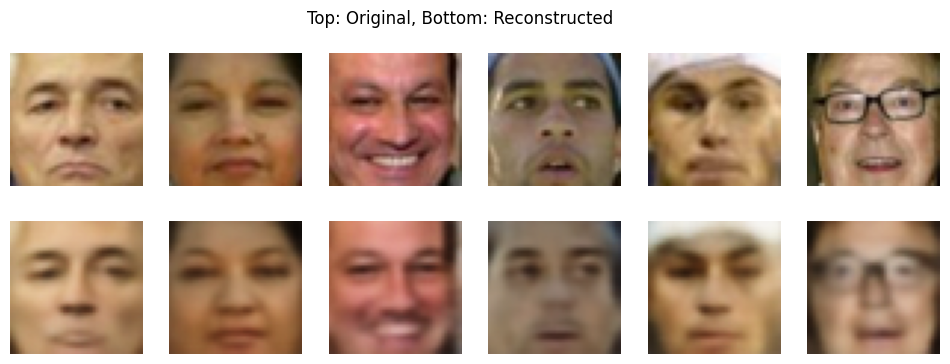

Epoch 12 | Train Loss: 0.0025 | Val Loss: 0.0025


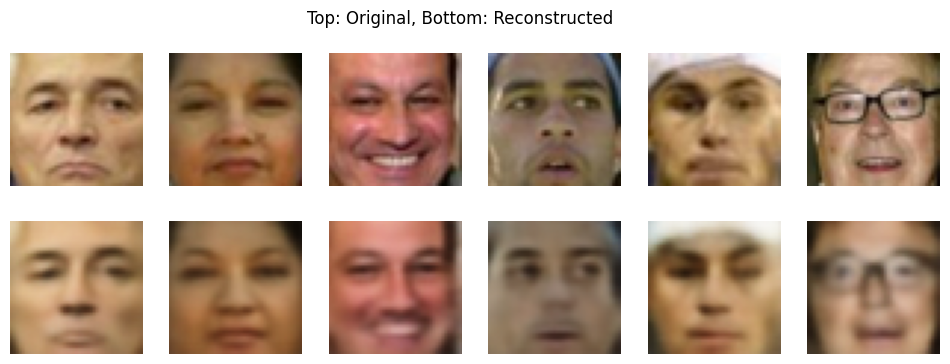

Epoch 13 | Train Loss: 0.0023 | Val Loss: 0.0024


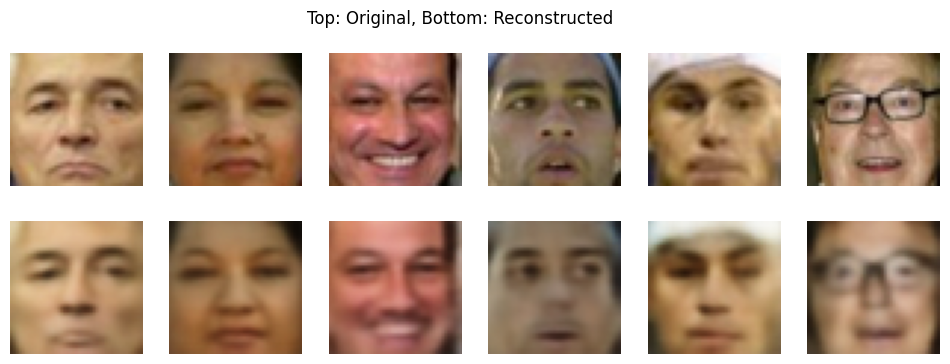

Epoch 14 | Train Loss: 0.0023 | Val Loss: 0.0024


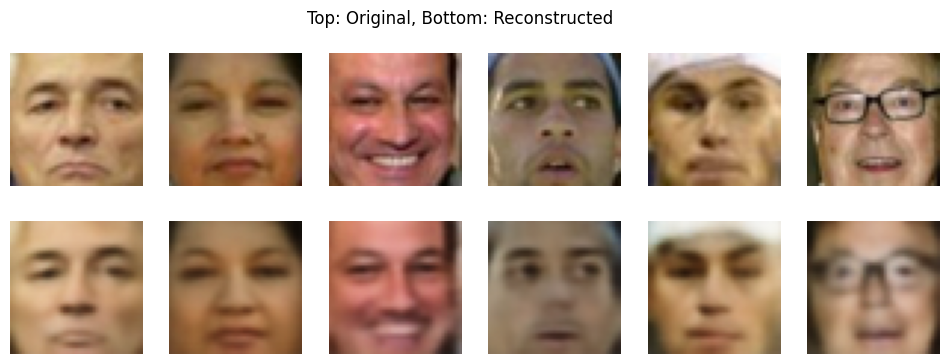

Epoch 15 | Train Loss: 0.0022 | Val Loss: 0.0023


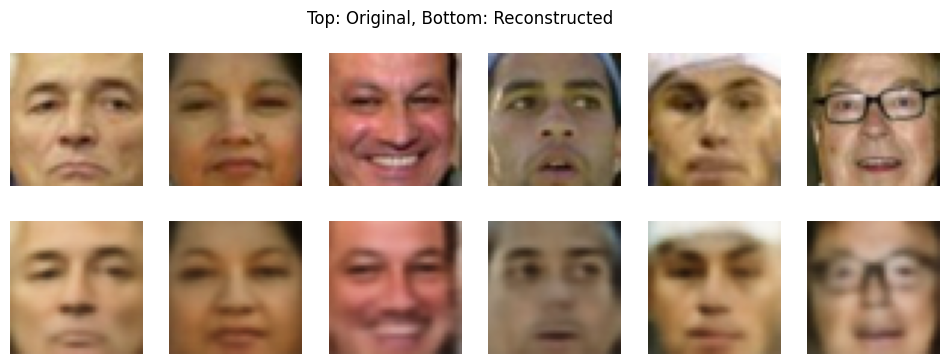

Epoch 16 | Train Loss: 0.0022 | Val Loss: 0.0023


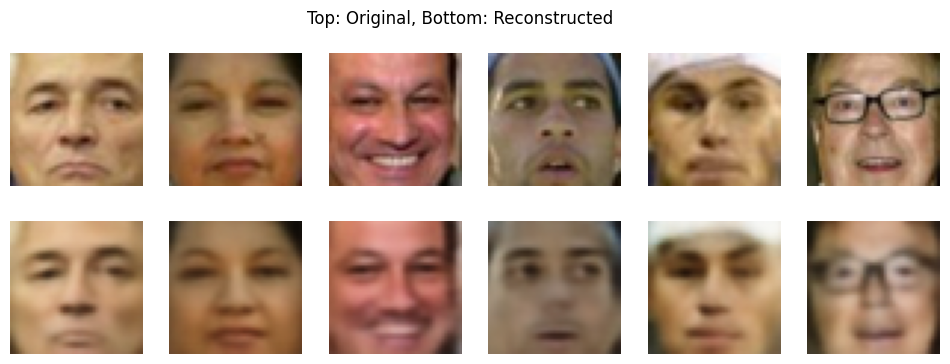

Epoch 17 | Train Loss: 0.0021 | Val Loss: 0.0023


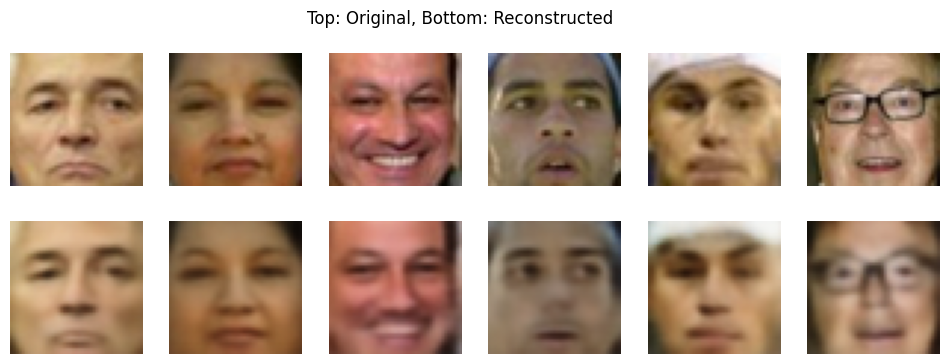

Epoch 18 | Train Loss: 0.0021 | Val Loss: 0.0022


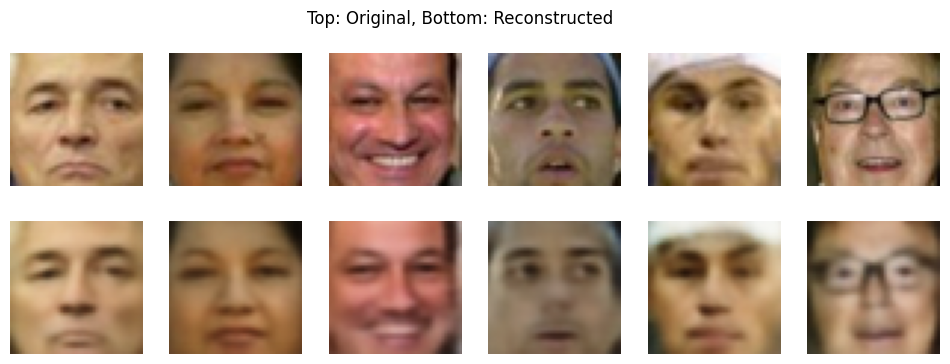

Epoch 19 | Train Loss: 0.0021 | Val Loss: 0.0022


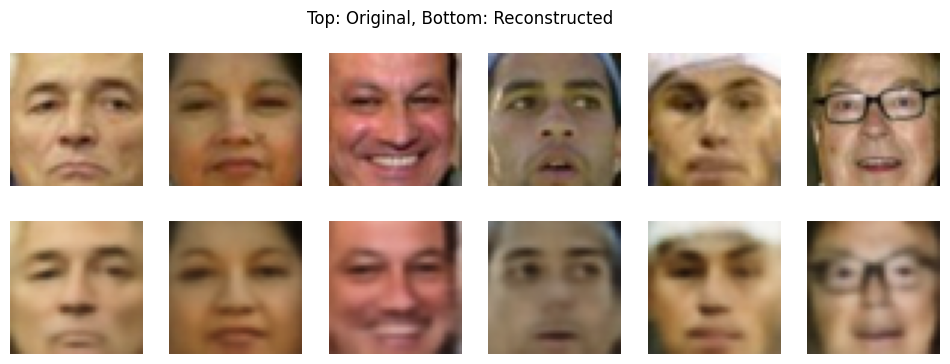

Epoch 20 | Train Loss: 0.0020 | Val Loss: 0.0022


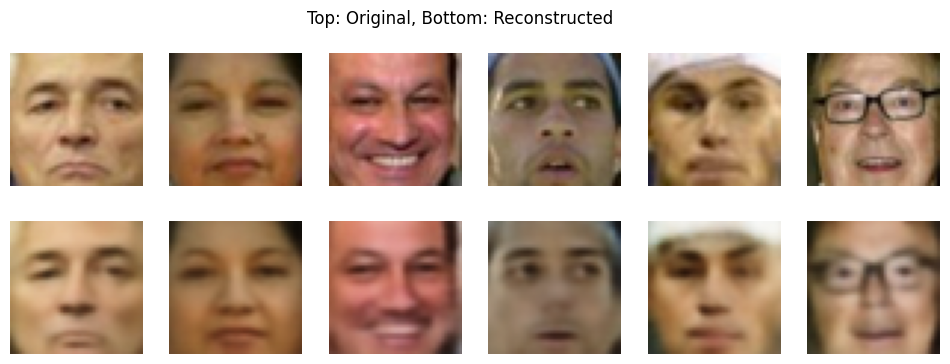

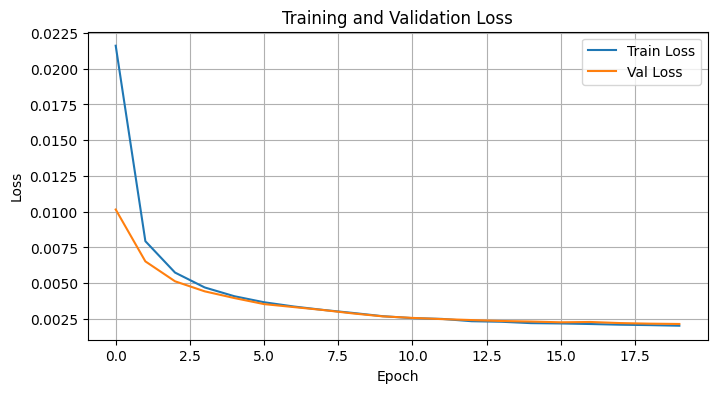

In [16]:
latent_vectors_train = []  # Список для латентных векторов обучающего набора
latent_vectors_val = []    # Список для латентных векторов валидационного набора
autoencoder = autoencoder.to(device)

for epoch in range(1, num_epochs + 1):
    autoencoder.train()
    total_train_loss = 0
    for batch, _ in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        # Извлекаем латентный вектор
        recon, latent_code = autoencoder(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * batch.size(0)

        latent_vectors_train.append(latent_code.detach().cpu().numpy())

    train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Валидация
    autoencoder.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch, _ in val_loader:
            batch = batch.to(device)
            recon, latent_code = autoencoder(batch)
            loss = criterion(recon, batch)
            total_val_loss += loss.item() * batch.size(0)

            # Сохраняем латентные векторы для анализа
            latent_vectors_val.append(latent_code.detach().cpu().numpy())

    val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Показываем реконструкции после каждой эпохи
    show_reconstructions(autoencoder, val_loader)

# График потерь
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ!

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

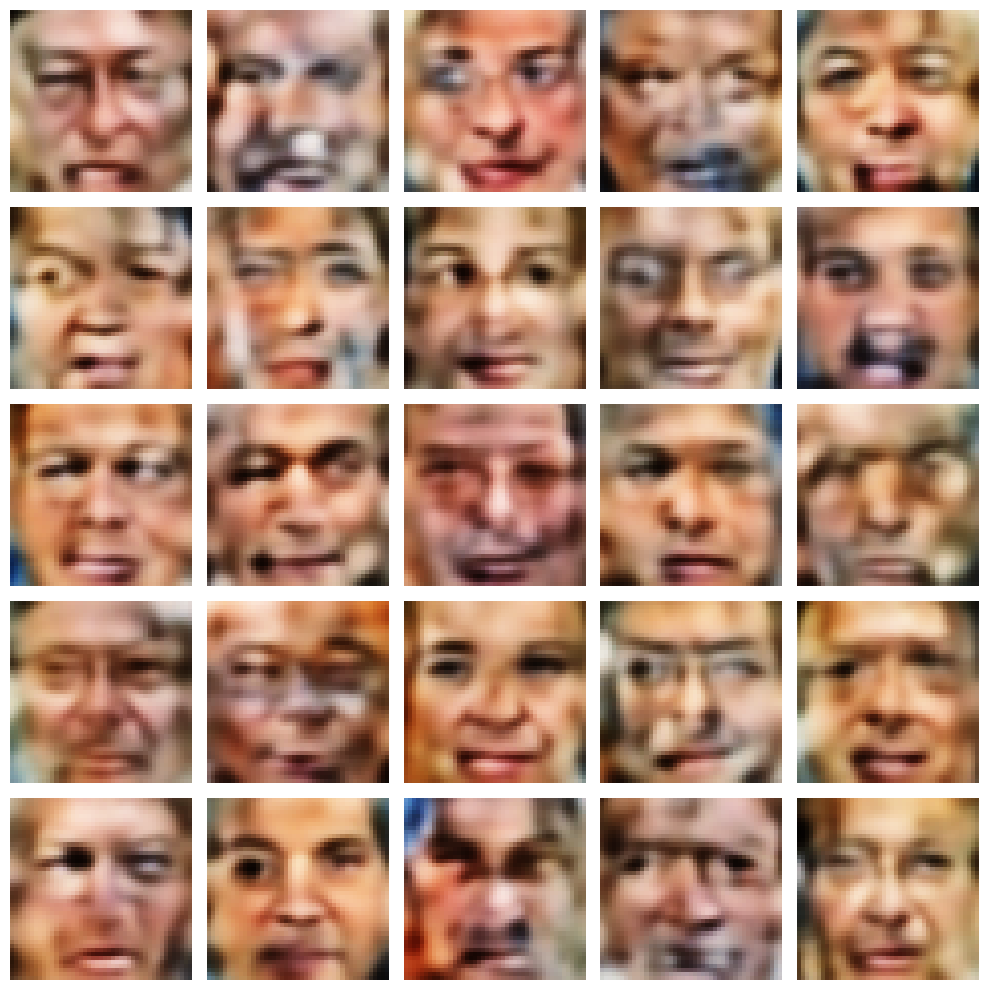

In [31]:

#Преобразуем список тензоров в один тензор с паддингом
latent_padded = torch.nn.utils.rnn.pad_sequence([t.to(device) for t in latent_vectors_train],
                                              batch_first=True,
                                              padding_value=0)
mask = (latent_padded != 0).any(dim=-1).float()
sum_latent = (latent_padded * mask.unsqueeze(-1)).sum(dim=0)
count_latent = mask.sum(dim=0).unsqueeze(-1).clamp(min=1)
mean_latent = sum_latent / count_latent
std_latent = torch.sqrt(((latent_padded - mean_latent).pow(2) * mask.unsqueeze(-1)).sum(dim=0) / count_latent)

#Генерация новых изображений
z = torch.randn(25, dim_code, device=device)
z = z * std_latent[0] + mean_latent[0]

with torch.no_grad():
    z = autoencoder.fc_dec(z)
    generated_images = autoencoder.decoder(z)

generated_images = generated_images.cpu().numpy()
generated_images = np.clip(generated_images, 0, 1)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].transpose(1, 2, 0))
    ax.axis('off')
plt.tight_layout()
plt.show()

Какие то мутанты получились :)


In [26]:

print(type(latent_vectors_train))  # Должен быть torch.Tensor или np.ndarray
print(len(latent_vectors_train))   # Должно быть 3300
print(latent_vectors_train[0].shape)

<class 'list'>
3300
torch.Size([64, 128])


## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с атрибутами, скачанный вместе с картинками. В нем указаны имена изображений и присутствубщие атрибуты (улыбки, очки и прочее интересное).

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [41]:
attrs["Smiling"]

0       -2.686594
1       -2.664484
2       -2.643547
3       -2.639749
4       -2.630769
           ...   
13138    2.737038
13139    2.743817
13140    2.781146
13141    2.791830
13142    2.839994
Name: Smiling, Length: 13143, dtype: float32

In [46]:
images.shape

(13143, 45, 45, 3)

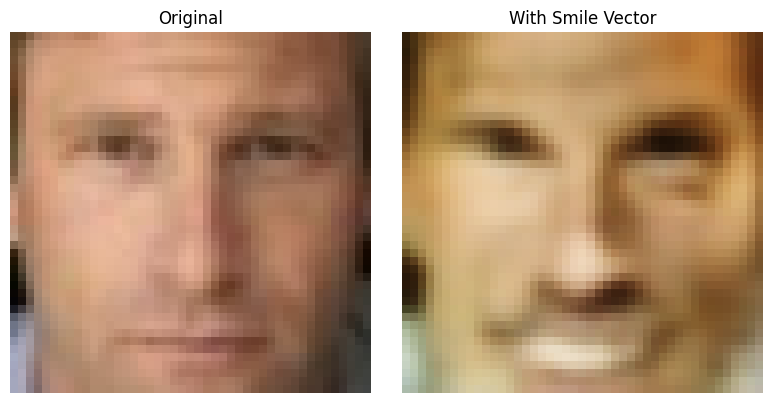

In [104]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Учитываем 3 канала (RGB) при нормализации
transform = T.Compose([
    T.ToTensor(),

])

# Обратная трансформация для RGB
def tensor_to_image(t):
    t = t.detach().cpu().squeeze(0)  # [C, H, W]
    t = t.clamp(0, 1)
    return t.permute(1, 2, 0).numpy()
# Конвертация изображения в латентный вектор
def get_latent(img, model):
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        z = model.encoder(x)
        z = z.view(z.size(0), -1)
        if hasattr(model, 'fc_enc'):
            z = model.fc_enc(z)
    return z

# Обратный путь: латентный -> изображение
def decode_latent(z, model):
    with torch.no_grad():
        if hasattr(model, 'fc_dec'):
            z = model.fc_dec(z)
        img = model.decoder(z)
    return img

# 1. Вычисляем вектор улыбки
smile_vecs = torch.stack([get_latent(images[i], autoencoder).squeeze(0) for i in attrs['Smiling'].nlargest(10).index])
neutral_vecs = torch.stack([get_latent(images[i], autoencoder).squeeze(0) for i in attrs['Smiling'].nsmallest(10).index])
smile_vector = neutral_vecs.mean(0) - smile_vecs.mean(0)

# 2. Применяем к нейтральному лицу
neutral_img = images[attrs['Smiling'].nsmallest(1).index[0]]
z = get_latent(neutral_img, autoencoder)
#коэффициент значимости улыбки
z_smile = z +2*smile_vector.unsqueeze(0)
output_img = decode_latent(z_smile, autoencoder)

# 3. Визуализация
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(neutral_img)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tensor_to_image(output_img))
plt.title('With Smile Vector')
plt.axis('off')
plt.tight_layout()
plt.show()

#вроде улыбка есть

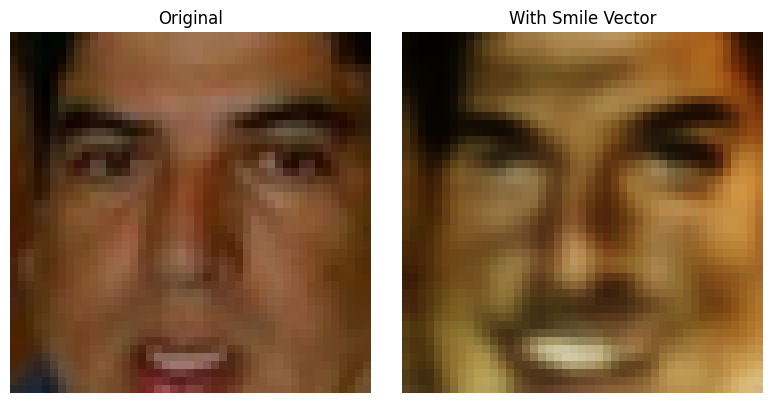

In [108]:
neutral_img = images[attrs['Smiling'].nsmallest(10).index[7]]
z = get_latent(neutral_img, autoencoder)
#коэффициент значимости улыбки
z_smile = z +2*smile_vector.unsqueeze(0)
output_img = decode_latent(z_smile, autoencoder)

# 3. Визуализация
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(neutral_img)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tensor_to_image(output_img))
plt.title('With Smile Vector')
plt.axis('off')
plt.tight_layout()
plt.show()

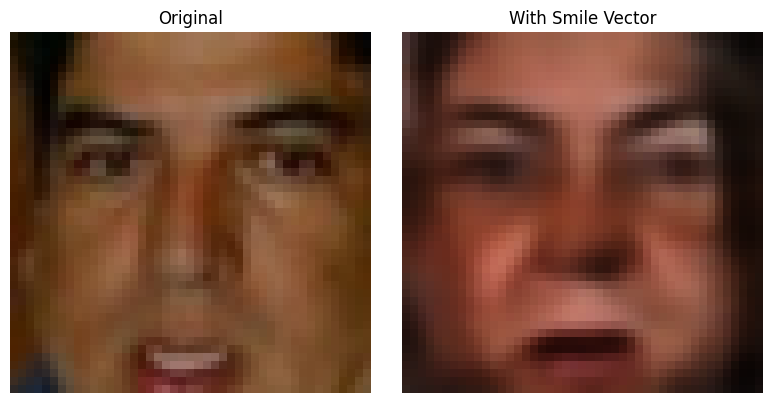

In [110]:
neutral_img = images[attrs['Smiling'].nsmallest(10).index[7]]
z = get_latent(neutral_img, autoencoder)
#коэффициент значимости улыбки
z_smile = z -2*smile_vector.unsqueeze(0)
output_img = decode_latent(z_smile, autoencoder)

# 3. Визуализация
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(neutral_img)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tensor_to_image(output_img))
plt.title('With Smile Vector')
plt.axis('off')
plt.tight_layout()
plt.show()
#если поменять коэффициент на отрицательный,то человек получается не такой уже улыбчивый :)

Вуаля! Вы восхитительны!

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [112]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 474kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.37MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.94MB/s]


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [159]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 256),
            nn.ReLU()
        )

        # Latent space
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logsigma = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64*7*7),
            nn.ReLU()
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # 28x28
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logsigma = self.fc_logsigma(h)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            sigma = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(sigma)
            return mu + eps * sigma
        else:
            return mu

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 64, 7, 7)
        reconstruction = self.decoder_conv(h)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [160]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    return F.binary_cross_entropy(reconstruction, x, reduction='sum')

def loss_vae(x, mu, logsigma, reconstruction):
    kl = KL_divergence(mu, logsigma)
    recon = log_likelihood(x, reconstruction)
    return kl + recon

И обучим модель:

In [161]:
criterion = loss_vae

vae = VAE().to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

Train Epoch: 0 [0/60000 (0%)]	Loss: 95.755562
Train Epoch: 0 [3200/60000 (5%)]	Loss: 93.755028
Train Epoch: 0 [6400/60000 (11%)]	Loss: 93.369438
Train Epoch: 0 [9600/60000 (16%)]	Loss: 88.372910
Train Epoch: 0 [12800/60000 (21%)]	Loss: 102.405807
Train Epoch: 0 [16000/60000 (27%)]	Loss: 85.859413
Train Epoch: 0 [19200/60000 (32%)]	Loss: 89.366753
Train Epoch: 0 [22400/60000 (37%)]	Loss: 89.647873
Train Epoch: 0 [25600/60000 (43%)]	Loss: 97.065094
Train Epoch: 0 [28800/60000 (48%)]	Loss: 95.533173
Train Epoch: 0 [32000/60000 (53%)]	Loss: 95.559082
Train Epoch: 0 [35200/60000 (59%)]	Loss: 101.586655
Train Epoch: 0 [38400/60000 (64%)]	Loss: 89.902313
Train Epoch: 0 [41600/60000 (69%)]	Loss: 99.569824
Train Epoch: 0 [44800/60000 (75%)]	Loss: 99.622063
Train Epoch: 0 [48000/60000 (80%)]	Loss: 89.582405
Train Epoch: 0 [51200/60000 (85%)]	Loss: 95.744812
Train Epoch: 0 [54400/60000 (91%)]	Loss: 93.798820
Train Epoch: 0 [57600/60000 (96%)]	Loss: 99.467133
====> Epoch: 0 Average loss: Train: 95

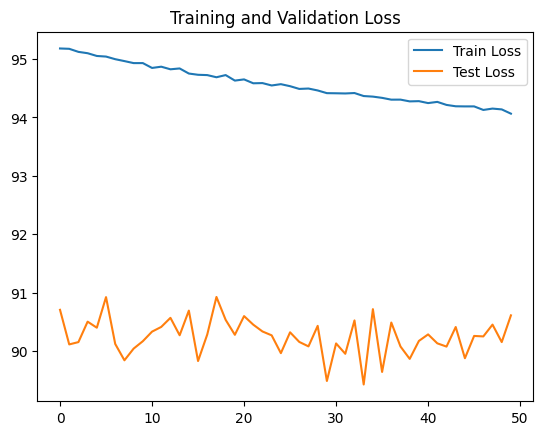

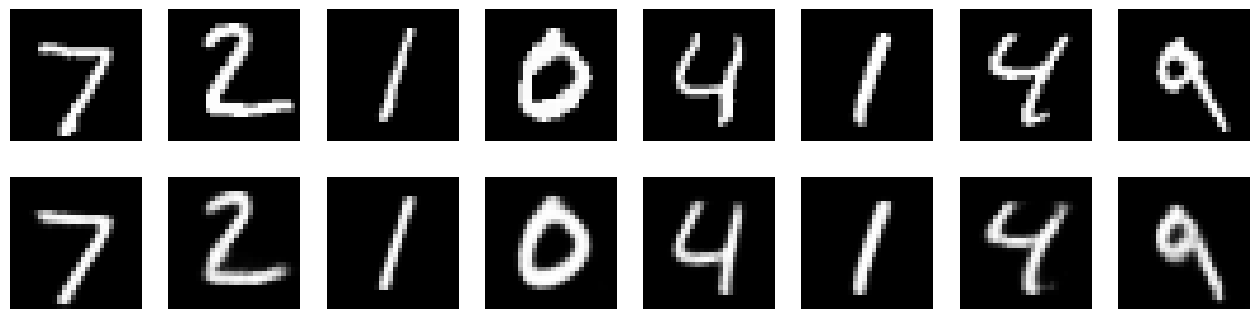

In [167]:
# Обучение
train_losses = []
test_losses = []
for epoch in range(50):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()
        mu, logsigma, recon_batch = vae(data)
        loss = criterion( data, mu, logsigma,recon_batch)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    # Средний лосс на эпохе
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Валидация
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            mu, logsigma, recon_batch = vae(data)
            test_loss += criterion(data, mu, logsigma,recon_batch).item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    print(f'====> Epoch: {epoch} Average loss: Train: {avg_train_loss:.4f}, Test: {avg_test_loss:.4f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

vae.eval()
with torch.no_grad():
    test_sample = next(iter(test_loader))[0][:8].to(device)
    _, _, recon_sample = vae(test_sample)

# Отображение оригинальных и реконструированных изображений
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(test_sample[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_sample[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')
plt.show()




Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

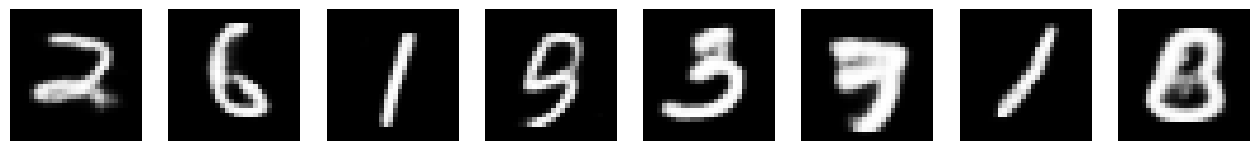

In [168]:
# Генерация новых изображений
with torch.no_grad():
    z = torch.randn(8, 20).to(device)
    generated = vae.decode(z)

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
    axes[i].imshow(generated[i].cpu().squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


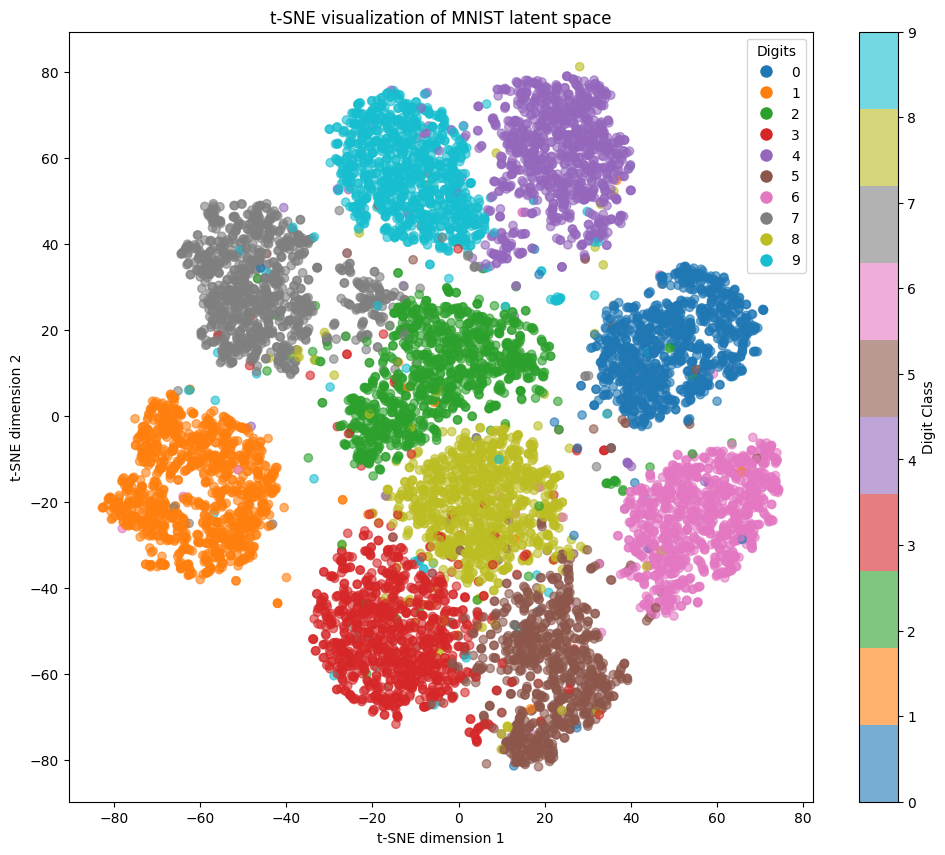

In [169]:
from sklearn.manifold import TSNE
latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        mu, _ = vae.encode(images)
        latent_vectors.append(mu.cpu().numpy())
        labels.append(targets.numpy())

latent_vectors = np.concatenate(latent_vectors)
labels = np.concatenate(labels)

# Применяем t-SNE для уменьшения размерности до 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
latent_2d = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Digit Class')
plt.title('t-SNE visualization of MNIST latent space')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')

classes = [str(i) for i in range(10)]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(i/10), markersize=10)
           for i in range(10)]
plt.legend(handles, classes, title='Digits')

plt.show()

# Что вы думаете о виде латентного представления?

Tsne отлично разбил на кластеры. Отсюда отлично видно, что близкие по схожести цифры находятся рядом (3 и 8, 4 и 9 например). Если группы перекрываются — значит, VAE путает эти цифры. Обученная модель создает четкие, разделенные группы.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [172]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, latent_dim=20, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(784 + num_classes, 400),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logsigma = nn.Linear(400, latent_dim)

        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        # Кодируем вектор
        one_hot = F.one_hot(class_num, num_classes=self.num_classes).float().to(x.device)
        # Соединяем изображение и вектор с инфой
        x = x.view(-1, 784)
        x = torch.cat([x, one_hot], dim=1)
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logsigma = self.fc_logsigma(h)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            sigma = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(sigma)
            return mu + eps * sigma
        else:
            return mu

    def decode(self, z, class_num):
        one_hot = F.one_hot(class_num, num_classes=self.num_classes).float().to(x.device)
        z = torch.cat([z, one_hot], dim=1)

        reconstruction = self.decoder(z)
        return reconstruction.view(-1, 1, 28, 28)

    def forward(self, x, class_num):
        mu, logsigma = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

    def generate(self, class_num, num_samples=1):
        """Generate samples for specific class"""
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim)
            if next(self.parameters()).is_cuda:
                z = z.cuda()
            # Генерируем для класса
            return self.decode(z, torch.tensor([class_num]*num_samples))

In [173]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(latent_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Функция потерь
def cvae_loss(recon_x, x, mu, logsigma):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return BCE + KLD

# Цикл обучения
for epoch in range(epochs):
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()
        mu, logsigma, recon_batch = model(data, labels)
        loss = cvae_loss(recon_batch, data, mu, logsigma)
        loss.backward()
        optimizer.step()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

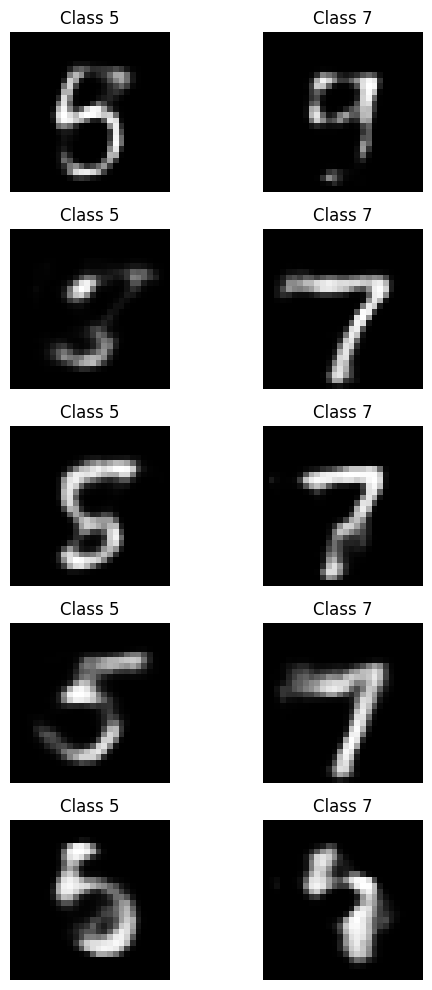

In [175]:
def generate_comparison(model, latent_dim=32, class1=5, class2=7, num_samples=5, device='cuda'):
    #Генерирует пары изображений из одного латентного вектора, но разных классов

    model.eval()

    # Генерируем случайные латентные векторы
    z = torch.randn(num_samples, latent_dim).to(device)

    # Создаем метки классов
    class1_tensor = torch.tensor([class1]*num_samples).to(device)
    class2_tensor = torch.tensor([class2]*num_samples).to(device)

    with torch.no_grad():
        images_class1 = model.decode(z, class1_tensor).cpu()
        images_class2 = model.decode(z, class2_tensor).cpu()

    fig, axes = plt.subplots(num_samples, 2, figsize=(6, 2*num_samples))

    for i in range(num_samples):
        axes[i, 0].imshow(images_class1[i].squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Class {class1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(images_class2[i].squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Class {class2}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

generate_comparison(model, class1=5, class2=7, num_samples=5)

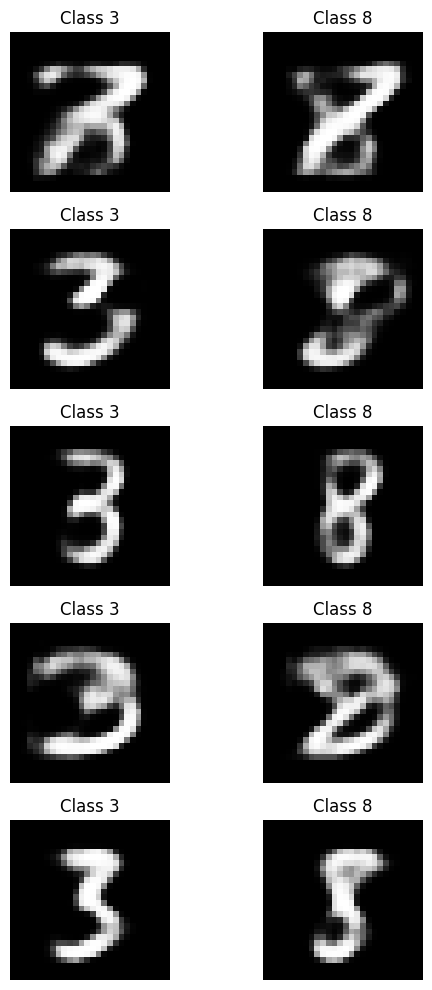

In [177]:
generate_comparison(model, class1=3, class2=8, num_samples=5)

Ну норм,понять можно :)


Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [178]:
def plot_cvae_latent_space(model, test_loader, device='cuda', n_samples=1000):

    model.eval()

    latent_vectors = []
    labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            # Получаем латентные представления
            mu, _ = model.encode(data, target)

            latent_vectors.append(mu.cpu().numpy())
            labels.append(target.cpu().numpy())

            if len(np.concatenate(latent_vectors)) >= n_samples:
                break

    latent_vectors = np.concatenate(latent_vectors)[:n_samples]
    labels = np.concatenate(labels)[:n_samples]

    # Применяем t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    latent_2d = tsne.fit_transform(latent_vectors)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)

    cbar = plt.colorbar(scatter, ticks=range(10))
    cbar.set_label('Digit Class')
    cbar.set_ticklabels([str(i) for i in range(10)])

    plt.title('t-SNE visualization of CVAE latent space (colored by digit class)')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


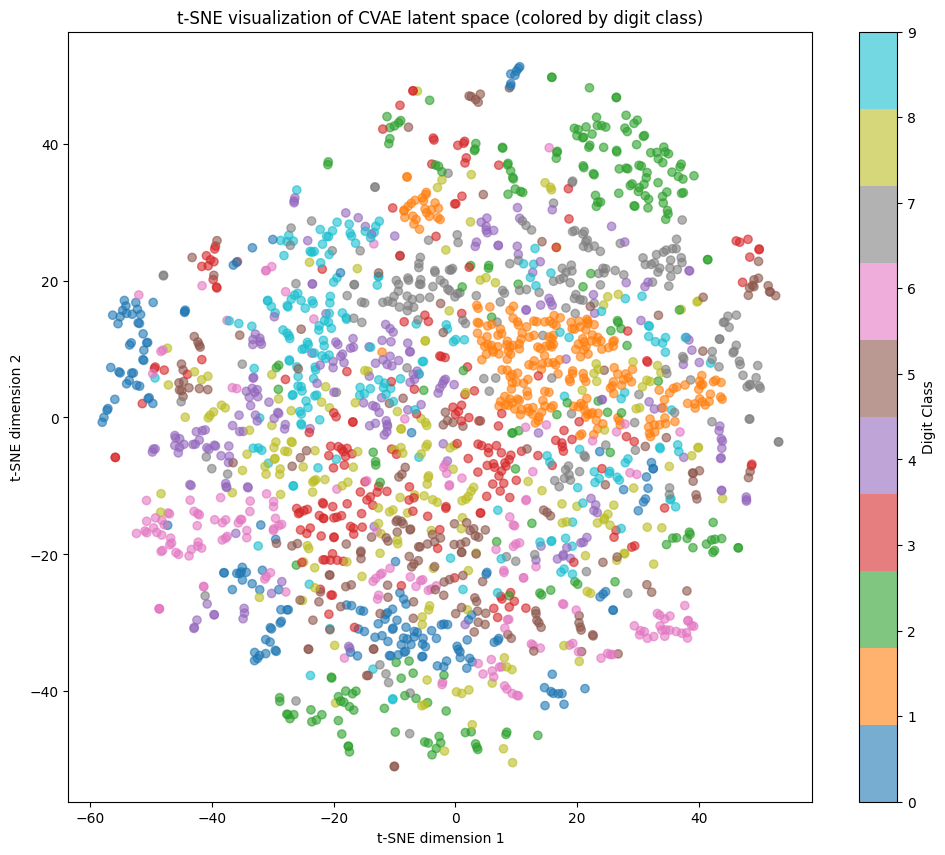

In [179]:
plot_cvae_latent_space(model, test_loader, device, n_samples=2000)

**Ну отсюда становится ясно ключевое отличие двух методов.**

В VAE энкодер вынужден кодировать всю информацию (и класс, и стиль) в одно латентное пространство → автоматически формирует кластеры по классам.

В CVAE класс явно подается на вход декодеру → латентное пространство может специализироваться только на стиле (наклоне, толщине линий и т.д.), а не на метке класса.

То есть кластеризация происходит по стилевым признакам, а не по классам. Те же цифры с похожим написанием будут ближе (например, "3" и "8" с закруглениями).

# BONUS 1: Denoising (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [1]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

NameError: name 'X' is not defined

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудьте разбить на train/test!>


In [ ]:
<тут проверка, как AE убирает шум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>